# Statistical Methods for Machine Learning
## Project - Neural Networks
## David Fernandez, 988346

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import seed
import seaborn as sns
import random
import cv2
import os
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from keras.layers import PReLU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier

import graphviz
import pydot
import visualkeras
from PIL import ImageFont

In [2]:
#set seed
seed(2022)
tf.random.set_seed(2022)

# 1. Data Preprocessing

## Let's see a sample of the data we are working with and how many images do we have

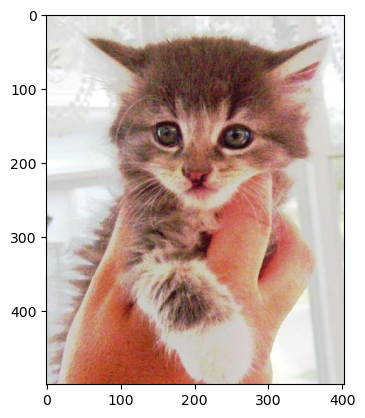

In [3]:
# Visualize an image from the Cats image folder
img=tf.keras.utils.load_img(r"D:\ML _Project\Data\Pictures\Cats\100.jpg")
plt.imshow(img)

In [4]:
# Sample image shape
cv2.imread(r"D:\ML _Project\Data\Pictures\Cats\100.jpg").shape

(500, 403, 3)

In [6]:
# Sample image pixel values, RGB
cv2.imread(r"D:\ML _Project\Data\Pictures\Cats\100.jpg")

array([[[219, 224, 223],
        [219, 224, 223],
        [219, 224, 223],
        ...,
        [249, 244, 246],
        [248, 243, 245],
        [246, 241, 243]],

       [[219, 224, 223],
        [219, 224, 223],
        [219, 224, 223],
        ...,
        [250, 245, 247],
        [249, 244, 246],
        [248, 243, 245]],

       [[218, 223, 222],
        [218, 223, 222],
        [218, 223, 222],
        ...,
        [250, 245, 246],
        [251, 246, 247],
        [252, 247, 248]],

       ...,

       [[221, 215, 208],
        [222, 216, 209],
        [218, 215, 207],
        ...,
        [211, 212, 216],
        [211, 212, 216],
        [211, 212, 216]],

       [[221, 215, 208],
        [222, 216, 209],
        [219, 216, 208],
        ...,
        [211, 212, 216],
        [211, 212, 216],
        [211, 212, 216]],

       [[222, 216, 209],
        [223, 217, 210],
        [219, 216, 208],
        ...,
        [211, 212, 216],
        [211, 212, 216],
        [211, 212, 216]]

In [3]:
#How many files do we have on each folder?
count = 0
for root_dir, cur_dir, files in os.walk(r"D:\ML _Project\Data\Pictures\Cats"):
    count += len(files)
print('Cats images count:', count)

count = 0
for root_dir, cur_dir, files in os.walk(r"D:\ML _Project\Data\Pictures\Dogs"):
    count += len(files)
print('Dogs images count:', count)

Cats images count: 12500
Dogs images count: 12500


# Read data into pixels array, then scale and label them

In [4]:
#set categories according to directory
directory = r"D:\ML _Project\Data\Pictures"
categories = ['Cats', 'Dogs'] #Cats will be labaled as 0, Dogs as 1

In [5]:
#resize images
img_size=150

data=[]

for category in categories:
    folder=os.path.join(directory, category)
    label=categories.index(category)
    for img in os.listdir(folder):
        img_path=os.path.join(folder, img)
        img_arr=cv2.imread(img_path)
        if img_arr is None:  #skip in case of encountering a damaged/incompatible image
            continue
        img_arr=cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, label])

Some images were presenting an error, so they had to be dropped.
Total dataset is of size 24,946

In [6]:
#check images size
print(len(data)) #check dataset size after dropping damaged images
print(len(data[random.randint(0,len(data))][0])) #check if the size of a random image is 150

24946
150


In [7]:
#shuffle dataset
random.Random(2022).shuffle(data) 

# Split dataset into features and labels

In [8]:
#split features and labels in data
X = []
y = []

for features, labels in data:
    X.append(features)
    y.append(labels)

In [9]:
#transform data to np arrays
X=np.array(X)
y=np.array(y)

In [10]:
#check lenght of features and labels
print(len(X))
print(len(y))

24946
24946


In [11]:
#scale features for easier processing
X=X/255 

In [12]:
#check shape
X.shape

(24946, 150, 150, 3)

# 2. Training and test split

In [13]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2022, test_size=0.30)

In [14]:
#check training and testing datasets shape
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (17462, 150, 150, 3)
Shape of y_train:  (17462,)
Shape of X_test:  (7484, 150, 150, 3)
Shape of y_test:  (7484,)


In [15]:
#re-shape y_train and y_test sets
y_train=y_train.reshape(len(y_train), 1)
y_test=y_test.reshape(len(y_test), 1)

In [46]:
#check results again
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (17462, 150, 150, 3)
Shape of y_train:  (17462, 1)
Shape of X_test:  (7484, 150, 150, 3)
Shape of y_test:  (7484, 1)


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

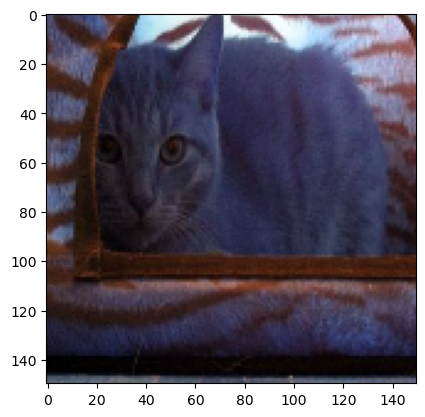

In [55]:
#random image from training set
plt.imshow(X_train[random.randint(0,len(X_train)), :])
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

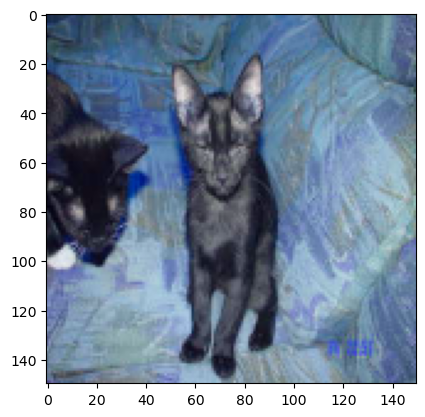

In [56]:
#random dog image from test set
plt.imshow(X_test[random.randint(0,len(X_test)), :])
plt.imshow

Save progress using Pickle

In [57]:
pickle.dump(X_train, open(r'D:\ML _Project\Data\pkl\X_train.pkl', "wb"))
pickle.dump(y_train, open(r'D:\ML _Project\Data\pkl\y_train.pkl', "wb"))
pickle.dump(X_test, open(r'D:\ML _Project\Data\pkl\X_test.pkl', "wb"))
pickle.dump(y_test, open(r'D:\ML _Project\Data\pkl\y_test.pkl', "wb"))

We'll load the data using pickle

In [3]:
X_train = pickle.load(open(r'D:\ML _Project\Data\pkl\X_train.pkl', "rb"))
y_train = pickle.load(open(r'D:\ML _Project\Data\pkl\y_train.pkl', "rb"))
X_test = pickle.load(open(r'D:\ML _Project\Data\pkl\X_test.pkl', "rb"))
y_test = pickle.load(open(r'D:\ML _Project\Data\pkl\y_test.pkl', "rb"))

# 3. Models and Results

## Model 1

In the first column of models, we'll start with a simplified version of a VGG model, combined with Dropout regularization, kernel initializer He uniform and early stopping to avoid overfitting and reduce training time

In [4]:
#def model 1

def create_model():
    model=Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
    return model

In [5]:
#create model
model=create_model()

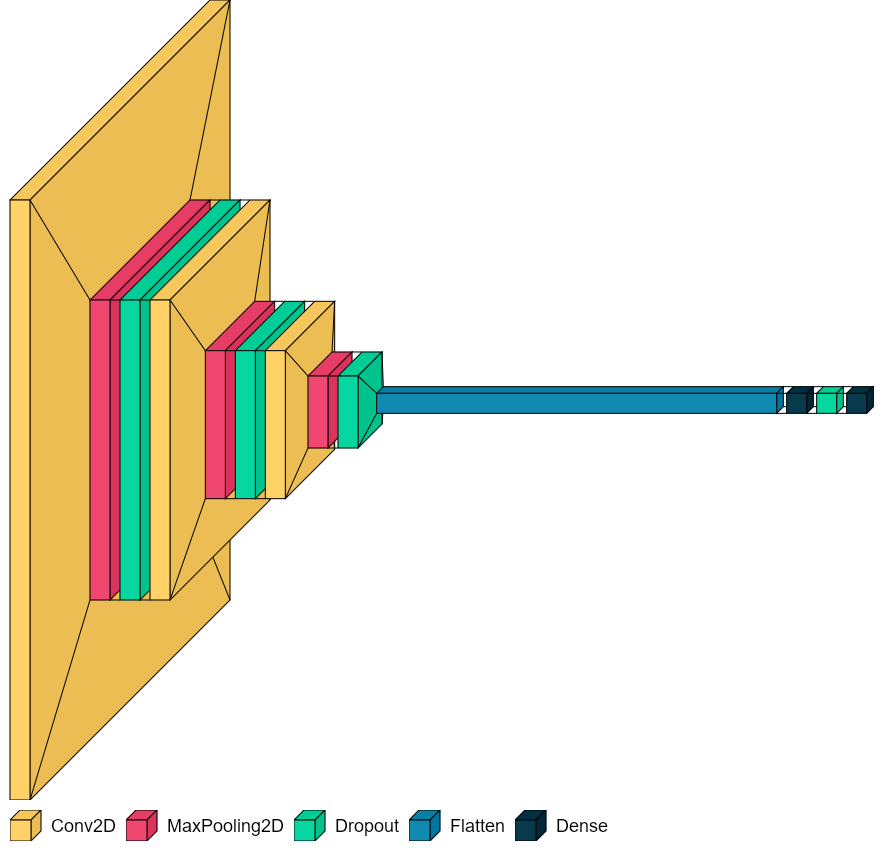

In [6]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, to_file="D:\ML _Project\Models\model1_1.png")

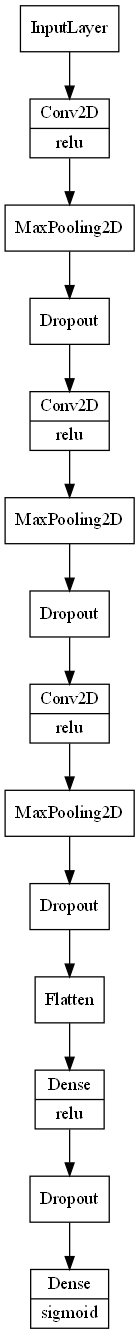

In [7]:
#visualize architecture
tf.keras.utils.plot_model(model, to_file="D:\ML _Project\Models\model1_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

In [8]:
#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

In [9]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_1', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=30, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [10]:
#set 5-fold Cross Validation and train model

n_folds=5
epochs=30
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify=y_train)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.5191
Epoch 1: val_loss improved from inf to 0.69150, saving model to model_1
INFO:tensorflow:Assets written to: model_1\assets
350/350 [==============================] - 142s 392ms/step - loss: 0.7326 - accuracy: 0.5191 - val_loss: 0.6915 - val_accuracy: 0.5222
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5584
Epoch 2: val_loss improved from 0.69150 to 0.68490, saving model to model_1
INFO:tensorflow:Assets written to: model_1\assets
350/350 [==============================] - 122s 348ms/step - loss: 0.6850 - accuracy: 0.5584 - val_loss: 0.6849 - val_accuracy: 0.6077
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.5818
Epoch 3: val_loss improved from 0.68490 to 0.68047, saving model to model_1
INFO:tensorflow:Assets written to: model_1\assets
350/350 [==============================] - 131s

350/350 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.5138
Epoch 1: val_loss did not improve from 0.52046
350/350 [==============================] - 132s 360ms/step - loss: 0.7176 - accuracy: 0.5138 - val_loss: 0.6890 - val_accuracy: 0.5115
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5293
Epoch 2: val_loss did not improve from 0.52046
350/350 [==============================] - 118s 337ms/step - loss: 0.6909 - accuracy: 0.5293 - val_loss: 0.6892 - val_accuracy: 0.5877
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5467
Epoch 3: val_loss did not improve from 0.52046
350/350 [==============================] - 118s 339ms/step - loss: 0.6866 - accuracy: 0.5467 - val_loss: 0.6850 - val_accuracy: 0.5648
Epoch 4/30
350/350 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.5655
Epoch 4: val_loss did not improve from 0.52046
350/350 [=========================

350/350 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.7844Restoring model weights from the end of the best epoch: 27.

Epoch 29: val_loss did not improve from 0.48070
350/350 [==============================] - 118s 337ms/step - loss: 0.4628 - accuracy: 0.7844 - val_loss: 0.4858 - val_accuracy: 0.7734
Epoch 29: early stopping
110/110 [==============================] - 9s 81ms/step - loss: 0.4889 - accuracy: 0.7598
Validation Score:  [0.4888870120048523, 0.7598053216934204]


Training on Fold:  4
Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.5158
Epoch 1: val_loss did not improve from 0.48070
350/350 [==============================] - 130s 360ms/step - loss: 0.7309 - accuracy: 0.5158 - val_loss: 0.6932 - val_accuracy: 0.5039
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5259
Epoch 2: val_loss did not improve from 0.48070
350/350 [==============================] - 119s 339ms

350/350 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.7786
Epoch 28: val_loss did not improve from 0.48070
350/350 [==============================] - 123s 350ms/step - loss: 0.4660 - accuracy: 0.7786 - val_loss: 0.4900 - val_accuracy: 0.7752
Epoch 29/30
350/350 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.7819
Epoch 29: val_loss improved from 0.48070 to 0.47756, saving model to model_1
INFO:tensorflow:Assets written to: model_1\assets
350/350 [==============================] - 119s 341ms/step - loss: 0.4564 - accuracy: 0.7819 - val_loss: 0.4776 - val_accuracy: 0.7666
Epoch 30/30
350/350 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.7915
Epoch 30: val_loss did not improve from 0.47756
110/110 [==============================] - 9s 86ms/step - loss: 0.4853 - accuracy: 0.7612
Validation Score:  [0.48525679111480713, 0.7612367868423462]


Training on Fold:  5
Epoch 1/30
350/350 [==============================] - 

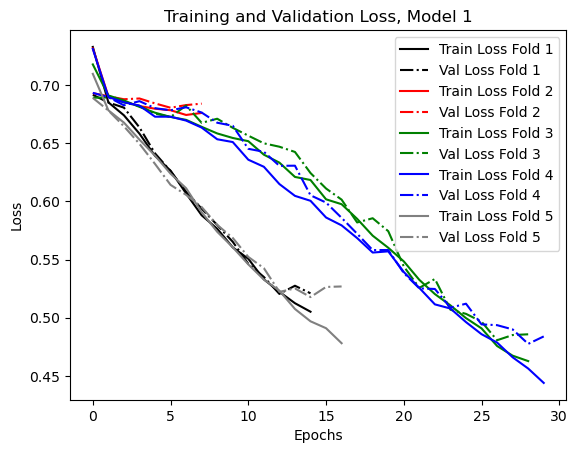

In [11]:
#Train and Validation Accuracy vs Epochs

plt.title('Training and Validation Loss, Model 1')

plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='grey', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='grey', linestyle = "dashdot")

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig(r'D:\ML _Project\Models\eval_model1.jpeg')
plt.show()

In [12]:
#average training loss
avg_model_1_train_loss=[]

avg_model_1_train_loss.append(np.mean(model_history[0].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[1].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[2].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[3].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[4].history['loss']))

print(np.mean(avg_model_1_train_loss)) #0.610444

0.6104443272386071


In [13]:
#average validation loss
avg_model_1_val_loss=[]

avg_model_1_val_loss.append(np.mean(model_history[0].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[1].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[2].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[3].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[4].history['val_loss']))

print(np.mean(avg_model_1_val_loss)) #0.616145057

0.6145057264691757


In [14]:
#load model
model = load_model('model_1')

In [15]:
#testing loss and accuracy
model.evaluate(X_test, y_test) #0.4859015

234/234 [==============================] - 18s 77ms/step - loss: 0.4859 - accuracy: 0.7696


[0.4859015643596649, 0.7696418762207031]

## Model 2



In [4]:
#def model 2

def create_model():
    model=Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False), metrics=['accuracy'])
    
    return model

In [5]:
#create model
model=create_model()

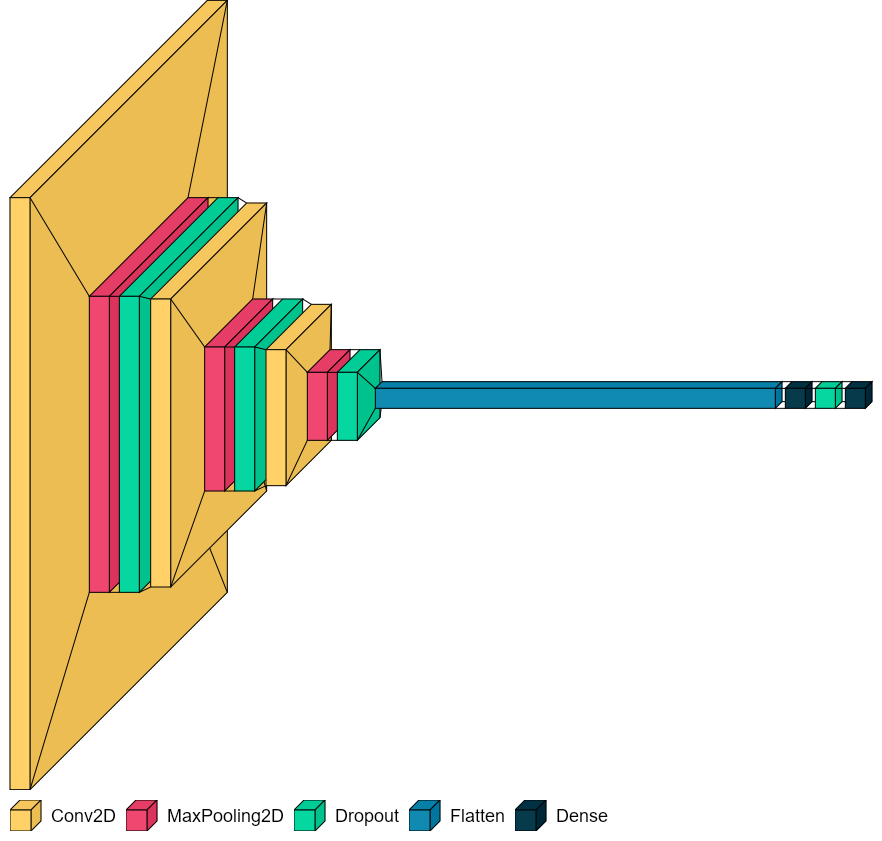

In [6]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, to_file="D:\ML _Project\Models\model2_1.png")

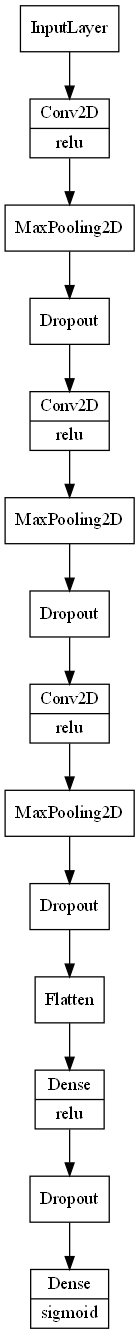

In [129]:
#visualize architecture
tf.keras.utils.plot_model(model, to_file="D:\ML _Project\Models\model2_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

In [130]:
#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 dropout_61 (Dropout)        (None, 36, 36, 64)      

In [131]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_2', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=30, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [132]:
#set 5-fold Cross Validation and train model

n_folds=5
epochs=30
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify=y_train)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5327
Epoch 1: val_loss improved from inf to 0.66660, saving model to model_2
INFO:tensorflow:Assets written to: model_2\assets
350/350 [==============================] - 138s 388ms/step - loss: 0.7059 - accuracy: 0.5327 - val_loss: 0.6666 - val_accuracy: 0.6195
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.6287
Epoch 2: val_loss improved from 0.66660 to 0.62261, saving model to model_2
INFO:tensorflow:Assets written to: model_2\assets
350/350 [==============================] - 133s 380ms/step - loss: 0.6489 - accuracy: 0.6287 - val_loss: 0.6226 - val_accuracy: 0.6546
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.6761
Epoch 3: val_loss improved from 0.62261 to 0.56074, saving model to model_2
INFO:tensorflow:Assets written to: model_2\assets
350/350 [==============================] - 126s

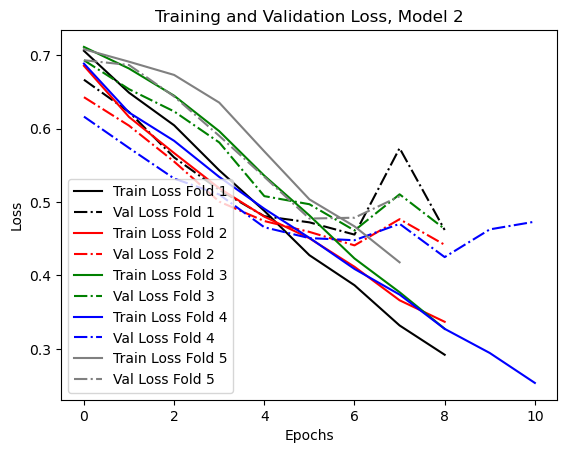

In [133]:
#Train and Validation Accuracy vs Epochs

plt.title('Training and Validation Loss, Model 2')

plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='grey', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='grey', linestyle = "dashdot")

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig(r'D:\ML _Project\Models\eval_model2.jpeg')
plt.show()

In [134]:
#average training loss model 2
avg_model_1_train_loss=[]

avg_model_1_train_loss.append(np.mean(model_history[0].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[1].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[2].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[3].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[4].history['loss']))

print(np.mean(avg_model_1_train_loss))

0.5111769399031847


In [135]:
#average validation loss model 2

avg_model_1_val_loss=[]

avg_model_1_val_loss.append(np.mean(model_history[0].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[1].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[2].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[3].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[4].history['val_loss']))

print(np.mean(avg_model_1_val_loss))

0.5339205230727341


In [136]:
#load model model 2
model = load_model('model_2')

In [137]:
#testing loss and accuracy model 2
model.evaluate(X_test, y_test)

234/234 [==============================] - 18s 75ms/step - loss: 0.4309 - accuracy: 0.8103


[0.4309137761592865, 0.8102619051933289]

## Model 3

In [138]:
#def model 3

def create_model():
    model=Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False), metrics=['accuracy'])
    
    return model

In [139]:
#create model
model=create_model()

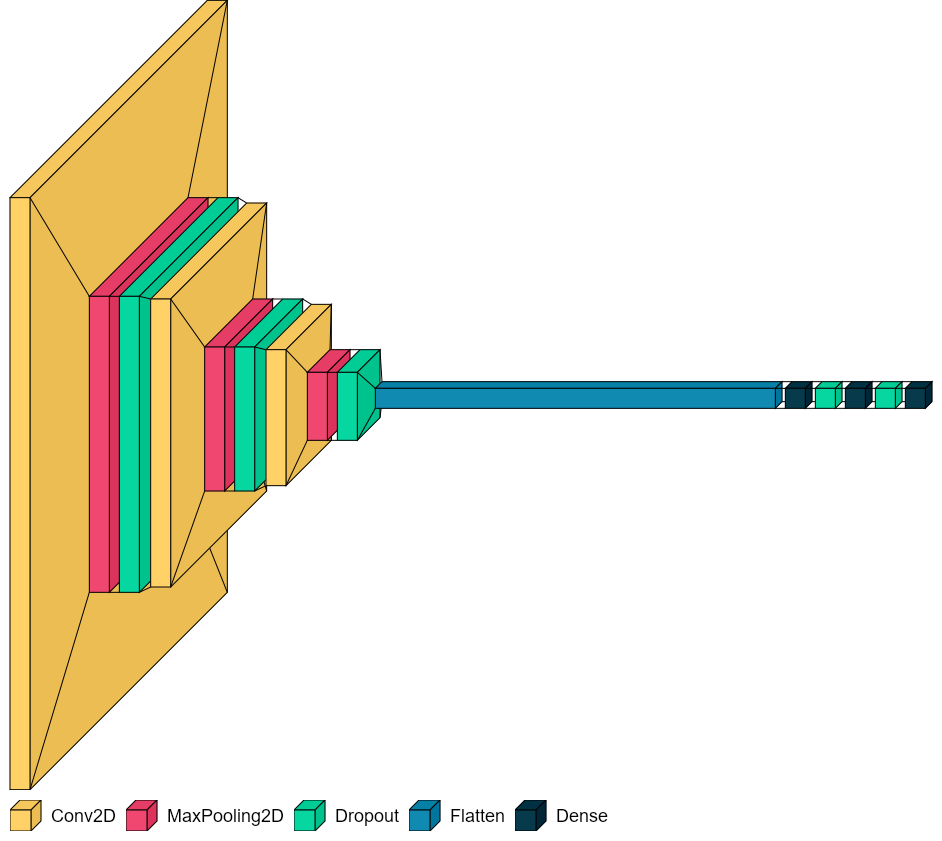

In [140]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, to_file="D:\ML _Project\Models\model3_1.png")

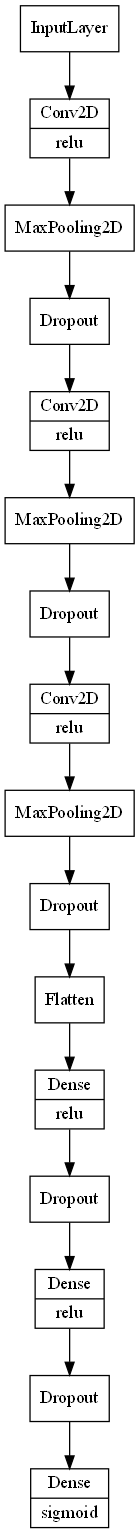

In [141]:
#visualize architecture
tf.keras.utils.plot_model(model, to_file="D:\ML _Project\Models\model3_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

In [142]:
#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 dropout_84 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_83 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 dropout_85 (Dropout)        (None, 36, 36, 64)      

In [143]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_3', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=30, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [144]:
#set 5-fold Cross Validation and train model

n_folds=5
epochs=30
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify=y_train)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.4991
Epoch 1: val_loss improved from inf to 0.69272, saving model to model_3
INFO:tensorflow:Assets written to: model_3\assets
350/350 [==============================] - 140s 395ms/step - loss: 0.7007 - accuracy: 0.4991 - val_loss: 0.6927 - val_accuracy: 0.5043
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5422
Epoch 2: val_loss improved from 0.69272 to 0.68124, saving model to model_3
INFO:tensorflow:Assets written to: model_3\assets
350/350 [==============================] - 124s 354ms/step - loss: 0.6878 - accuracy: 0.5422 - val_loss: 0.6812 - val_accuracy: 0.5573
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.5858
Epoch 3: val_loss improved from 0.68124 to 0.63156, saving model to model_3
INFO:tensorflow:Assets written to: model_3\assets
350/350 [==============================] - 124s

Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.5787
Epoch 3: val_loss did not improve from 0.45967
350/350 [==============================] - 121s 346ms/step - loss: 0.6764 - accuracy: 0.5787 - val_loss: 0.6709 - val_accuracy: 0.5755
Epoch 4/30
350/350 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.6400
Epoch 4: val_loss did not improve from 0.45967
350/350 [==============================] - 121s 345ms/step - loss: 0.6362 - accuracy: 0.6400 - val_loss: 0.6102 - val_accuracy: 0.6657
Epoch 5/30
350/350 [==============================] - ETA: 0s - loss: 0.5744 - accuracy: 0.7063
Epoch 5: val_loss did not improve from 0.45967
350/350 [==============================] - 120s 344ms/step - loss: 0.5744 - accuracy: 0.7063 - val_loss: 0.5230 - val_accuracy: 0.7434
Epoch 6/30
350/350 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7489
Epoch 6: val_loss did not improve from 0.45967
350/350 [==============

Epoch 7/30
350/350 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.7728
Epoch 7: val_loss did not improve from 0.43821
350/350 [==============================] - 121s 346ms/step - loss: 0.4813 - accuracy: 0.7728 - val_loss: 0.5148 - val_accuracy: 0.7523
Epoch 8/30
350/350 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.7943
Epoch 8: val_loss did not improve from 0.43821
350/350 [==============================] - 121s 346ms/step - loss: 0.4418 - accuracy: 0.7943 - val_loss: 0.5388 - val_accuracy: 0.7391
Epoch 8: early stopping
110/110 [==============================] - 10s 87ms/step - loss: 0.5359 - accuracy: 0.7432
Validation Score:  [0.535863995552063, 0.7432006597518921]




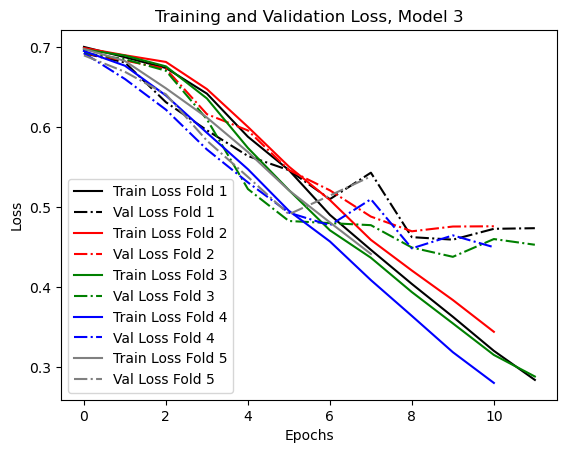

In [145]:
#Train and Validation Accuracy vs Epochs

plt.title('Training and Validation Loss, Model 3')

plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='grey', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='grey', linestyle = "dashdot")

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig(r'D:\ML _Project\Models\eval_model3.jpeg')
plt.show()

In [146]:
#average training loss model 3
avg_model_1_train_loss=[]

avg_model_1_train_loss.append(np.mean(model_history[0].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[1].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[2].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[3].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[4].history['loss']))

print(np.mean(avg_model_1_train_loss))

0.5284030061779601


In [147]:
#average validation loss model 3

avg_model_1_val_loss=[]

avg_model_1_val_loss.append(np.mean(model_history[0].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[1].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[2].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[3].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[4].history['val_loss']))

print(np.mean(avg_model_1_val_loss))

0.5555937791864076


In [148]:
#load model model 3
model = load_model('model_3')

In [149]:
#testing loss and accuracy model 3
model.evaluate(X_test, y_test)

234/234 [==============================] - 19s 82ms/step - loss: 0.4410 - accuracy: 0.8021


[0.4409886598587036, 0.8021111488342285]

# Model 4

In [70]:
#def model 4

def create_model():
    model=Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01), padding='valid', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal',
                     kernel_regularizer=tf.keras.regularizers.L2(0.01), padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal', 
                   kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(BatchNormalization())
        
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal', 
                    kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(BatchNormalization())
        
    model.add(Dense(32, activation='relu', kernel_initializer='glorot_normal',
                   kernel_regularizer=tf.keras.regularizers.L2(0.01)))
    model.add(BatchNormalization())
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False), metrics=['accuracy'])
    
    return model

In [71]:
#create model
model=create_model()

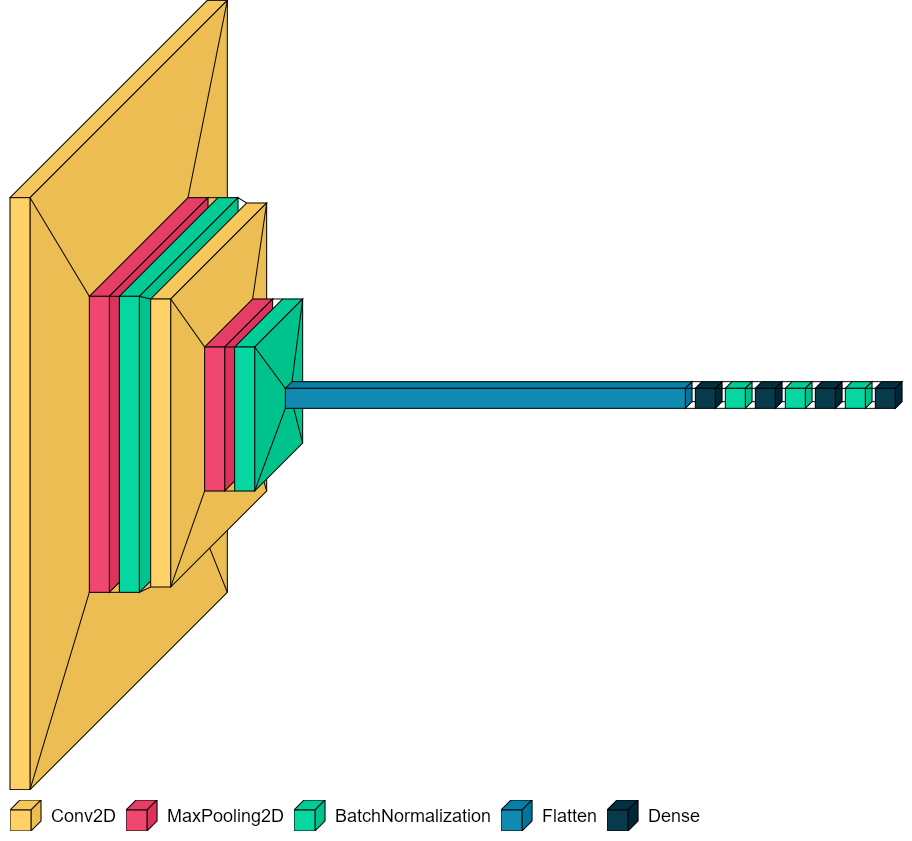

In [72]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, to_file="D:\ML _Project\Models\model4_1.png")

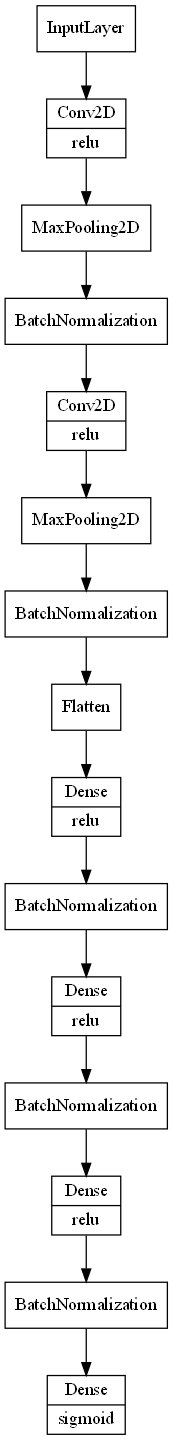

In [73]:
#visualize architecture
tf.keras.utils.plot_model(model, to_file="D:\ML _Project\Models\model4_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

In [74]:
#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_110 (Ba  (None, 74, 74, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_99 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                     

In [75]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_4', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=30, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [76]:
#set 5-fold Cross Validation and train model

n_folds=5
epochs=30
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify=y_train)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 3.0904 - accuracy: 0.6285
Epoch 1: val_loss improved from inf to 1.79745, saving model to model_4
INFO:tensorflow:Assets written to: model_4\assets
350/350 [==============================] - 110s 300ms/step - loss: 3.0904 - accuracy: 0.6285 - val_loss: 1.7975 - val_accuracy: 0.5347
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 1.4570 - accuracy: 0.6726
Epoch 2: val_loss improved from 1.79745 to 1.25925, saving model to model_4
INFO:tensorflow:Assets written to: model_4\assets
350/350 [==============================] - 91s 259ms/step - loss: 1.4570 - accuracy: 0.6726 - val_loss: 1.2593 - val_accuracy: 0.6850
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.6906
Epoch 3: val_loss did not improve from 1.25925
350/350 [==============================] - 88s 253ms/step - loss: 1.2469 - accuracy: 0.6906 - val_loss: 1.3846 - val_accuracy: 

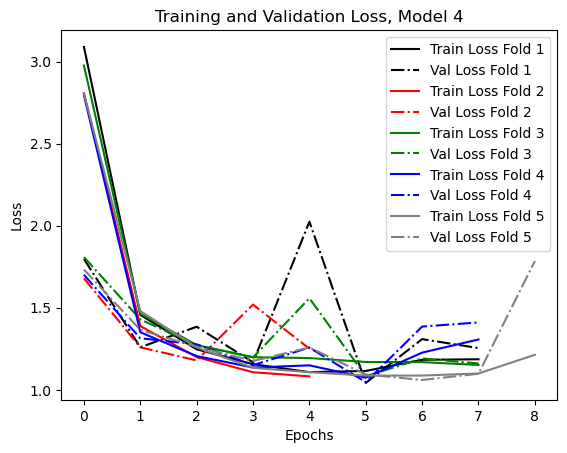

In [77]:
#Train and Validation Accuracy vs Epochs

plt.title('Training and Validation Loss, Model 4')

plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='grey', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='grey', linestyle = "dashdot")

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig(r'D:\ML _Project\Models\eval_model4.jpeg')
plt.show()

In [78]:
#average training loss model 4
avg_model_1_train_loss=[]

avg_model_1_train_loss.append(np.mean(model_history[0].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[1].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[2].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[3].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[4].history['loss']))

print(np.mean(avg_model_1_train_loss))

1.4356748159064185


In [79]:
#average validation loss model 4

avg_model_1_val_loss=[]

avg_model_1_val_loss.append(np.mean(model_history[0].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[1].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[2].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[3].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[4].history['val_loss']))

print(np.mean(avg_model_1_val_loss))

1.350473578373591


In [80]:
#load model model 4
model = load_model('model_4')

In [81]:
#testing loss and accuracy model 4
model.evaluate(X_test, y_test)

234/234 [==============================] - 14s 60ms/step - loss: 1.0488 - accuracy: 0.6940


[1.0487693548202515, 0.6940138936042786]

# Model 5

In [56]:
#def model 5

def create_model():
    model=Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,(3,3),activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(3,3),activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512,activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256,activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False), metrics=['accuracy'])
    
    return model

In [57]:
#create model
model=create_model()

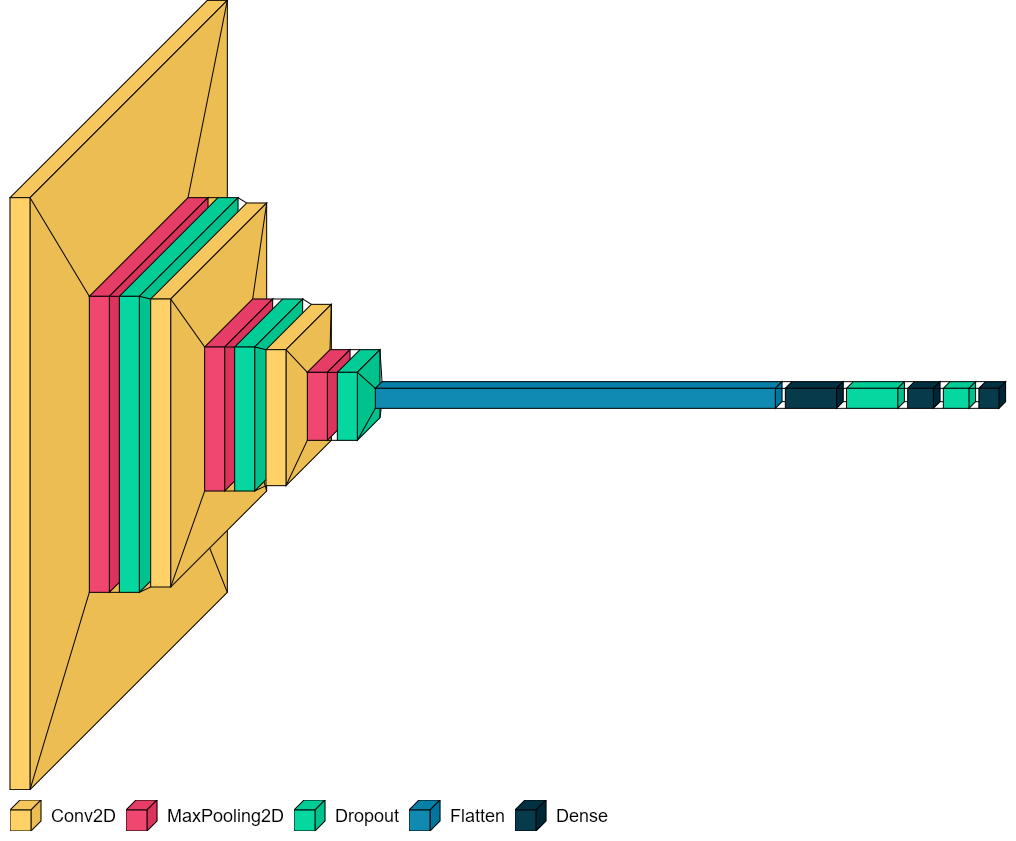

In [58]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, to_file="D:\ML _Project\Models\model5_1.png")

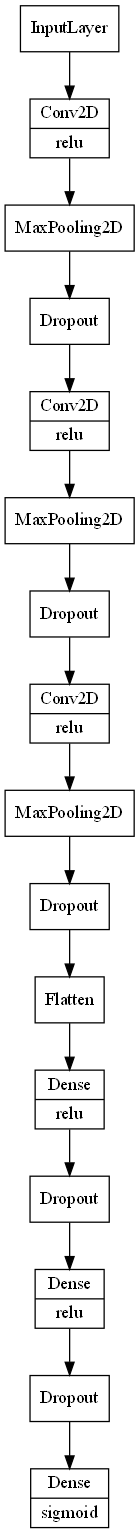

In [59]:
#visualize architecture
tf.keras.utils.plot_model(model, to_file="D:\ML _Project\Models\model5_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

In [60]:
#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 dropout_136 (Dropout)       (None, 74, 74, 32)        0         
                                                                 
 conv2d_73 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 dropout_137 (Dropout)       (None, 36, 36, 64)      

In [61]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=30, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [62]:
#set 5-fold Cross Validation and train model

n_folds=5
epochs=30
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify=y_train)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5445
Epoch 1: val_loss improved from inf to 0.68038, saving model to model_5
INFO:tensorflow:Assets written to: model_5\assets
350/350 [==============================] - 160s 447ms/step - loss: 0.7040 - accuracy: 0.5445 - val_loss: 0.6804 - val_accuracy: 0.5716
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.5900
Epoch 2: val_loss improved from 0.68038 to 0.65571, saving model to model_5
INFO:tensorflow:Assets written to: model_5\assets
350/350 [==============================] - 152s 435ms/step - loss: 0.6698 - accuracy: 0.5900 - val_loss: 0.6557 - val_accuracy: 0.6113
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.6295 - accuracy: 0.6486
Epoch 3: val_loss did not improve from 0.65571
350/350 [==============================] - 140s 396ms/step - loss: 0.6295 - accuracy: 0.6486 - val_loss: 0.6733 - val_accuracy

In [69]:
model_history

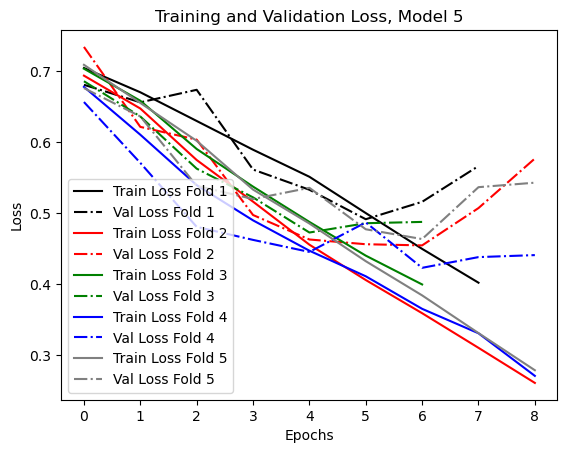

In [63]:
#Train and Validation Accuracy vs Epochs

plt.title('Training and Validation Loss, Model 5')

plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")

plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='grey', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='grey', linestyle = "dashdot")

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig(r'D:\ML _Project\Models\eval_model5.jpeg')
plt.show()

In [64]:
#average training loss model 5
avg_model_1_train_loss=[]

avg_model_1_train_loss.append(np.mean(model_history[0].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[1].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[2].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[3].history['loss']))
avg_model_1_train_loss.append(np.mean(model_history[4].history['loss']))

print(np.mean(avg_model_1_train_loss))

0.5053580549501238


In [65]:
#average validation loss model 5

avg_model_1_val_loss=[]

avg_model_1_val_loss.append(np.mean(model_history[0].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[1].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[2].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[3].history['val_loss']))
avg_model_1_val_loss.append(np.mean(model_history[4].history['val_loss']))

print(np.mean(avg_model_1_val_loss))

0.5434882557936132


In [66]:
#load model model 5
model = load_model('model_5')

In [67]:
#testing loss and accuracy model 5
model.evaluate(X_test, y_test)

234/234 [==============================] - 22s 92ms/step - loss: 0.4254 - accuracy: 0.8088


[0.42535021901130676, 0.8087921142578125]

# Ensemble Models predictions
Taken from https://github.com/bnsreenu/python_for_microscopists/blob/master/213-ensemble_sign_language.py

In [185]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('model_1')
model2 = load_model('model_2')
model3 = load_model('model_3')
model4 = load_model('model_4')
model5 = load_model('model_5')

models = [model1, model2, model3, model4, model5]

preds = [model.predict(X_test) for model in models]
preds=np.array(preds)
summed = np.mean(preds, axis=0)

ensemble_prediction =np.round(np.clip(summed, 0, 1))

prediction1 = model1.predict(X_test)
prediction2 = model2.predict(X_test)
prediction3 = model3.predict(X_test)
prediction4 = model4.predict(X_test)
prediction5 = model5.predict(X_test)

accuracy1 = model1.evaluate(X_test, y_test)[1]
accuracy2 = model2.evaluate(X_test, y_test)[1]
accuracy3 = model3.evaluate(X_test, y_test)[1]
accuracy4 = model4.evaluate(X_test, y_test)[1]
accuracy5 = model5.evaluate(X_test, y_test)[1]
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for model4 = ', accuracy4)
print('Accuracy Score for model5 = ', accuracy5)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

234/234 [==============================] - 20s 84ms/step - loss: 0.4254 - accuracy: 0.8088
Accuracy Score for model1 =  0.7696418762207031
Accuracy Score for model2 =  0.8102619051933289
Accuracy Score for model3 =  0.8021111488342285
Accuracy Score for model4 =  0.6940138936042786
Accuracy Score for model5 =  0.8087921142578125
Accuracy Score for average ensemble =  0.8260288615713522
